In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.metrics import RocCurveDisplay, auc, mean_absolute_error, roc_curve

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print('Root:', PATH_ROOT)

Root: /home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print('Output:', path_output)
create_dir(path_output)

Output: /home/lukec/workspace/diva_01/results_plot


In [4]:
def get_pivot_by_difficulty(df: pd.DataFrame, threshold: float=None) -> pd.DataFrame: 
    df_ = df[['Difficulty', 'Rate', 'Similarity']]

    if threshold is None:
        for i in np.arange(0.05, 0.5, 0.01):
            threshold = i
            results = (1 - df_['Similarity']) >= threshold
            df_['Prediction'] = results.astype(int)
            # count = df_['Prediction'][(df_['Rate'] == 0) & (df_['Difficulty'] == 'Easy')].sum()
            # if count == 0:
                # break
            count = df_['Prediction'][(df_['Rate'] == 0) & (df_['Difficulty'] == 'Normal')].sum()
            if count <= 1:
                break
    else:
        results = (1 - df_['Similarity']) >= threshold
        df_['Prediction'] = results.astype(int)
    print('Threshold:', threshold)

    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    return df_pivot

In [5]:
paths = [] 
paths.append(os.path.join(PATH_ROOT, 'results', 'synth', 'baseline', 'synth_alfa_svm_knndefense.csv'))
paths.append(os.path.join(PATH_ROOT, 'results', 'synth', 'baseline', 'synth_falfa_nn_knndefense.csv'))

# Checking the threshold for each attack
for p in paths:
    df_ = pd.read_csv(p)
    pivot_table = get_pivot_by_difficulty(df_)
    print(pivot_table)

Threshold: 0.32000000000000006
Dataset Difficulty  Easy  Normal  Hard
Poisoning Rate                        
0.00                   0       1    31
0.05                   0      16    49
0.10                   0      30    50
0.15                   5      33    50
0.20                   9      37    50
0.25                  14      41    50
0.30                  17      41    50
0.35                  18      41    49
0.40                  19      42    49
Threshold: 0.32000000000000006
Dataset Difficulty  Easy  Normal  Hard
Poisoning Rate                        
0.00                   0       1    31
0.05                   0      16    48
0.10                   0      31    50
0.15                   0      34    50
0.20                   0      38    50
0.25                   0      36    50
0.30                   1      37    50
0.35                   0      24    47
0.40                   0      16    38


In [6]:
pivot_tables = []
threshold = 0.32
for att in ['falfa_nn', 'alfa_svm']:
    df_ = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'baseline', f'synth_{att}_knndefense.csv'))
    pivot_table = get_pivot_by_difficulty(df_, threshold)
    pivot_table.to_csv(os.path.join(path_output, f'synth_pivot_baseline_difficulty_{att}.csv'))

    pivot_table = pivot_table.reset_index()
    pivot_tables.append(pivot_table)
        
pivot_1 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_1 = pivot_1 * 2

print(pivot_1)

Threshold: 0.32
Threshold: 0.32
Dataset Difficulty  Easy  Normal   Hard
Poisoning Rate                         
0.00                 0.0     2.0   62.0
0.05                 0.0    32.0   96.0
0.10                 0.0    60.0  100.0
0.15                 4.0    68.0  100.0
0.20                 8.0    76.0  100.0
0.25                14.0    76.0  100.0
0.30                18.0    78.0  100.0
0.35                18.0    64.0   96.0
0.40                20.0    58.0   88.0


In [7]:
def get_pivot_by_noise(df: pd.DataFrame, threshold: float=None) -> pd.DataFrame: 
    df_ = df[['Noise', 'Rate', 'Similarity']]

    if threshold is None:
        for i in np.arange(0.05, 0.5, 0.01):
            threshold = i
            results = (1 - df_['Similarity']) >= threshold
            df_['Prediction'] = results.astype(int)

            count = df_['Prediction'][(df_['Rate'] == 0) & (df_['Noise'] == 0.)].sum()
            if count <= 1:
                break
    else:
        results = (1 - df_['Similarity']) >= threshold
        df_['Prediction'] = results.astype(int)
    print('Threshold:', threshold)

    df_ = df_.rename(columns = {'Noise':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
    return df_pivot

In [8]:
paths = [] 
paths.append(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'baseline', 'synth_alfa_svm_knndefense.csv'))
paths.append(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'baseline', 'synth_falfa_nn_knndefense.csv'))

# Checking the threshold for each attack
for p in paths:
    df_ = pd.read_csv(p)
    pivot_table = get_pivot_by_noise(df_)
    print(pivot_table)

Threshold: 0.37000000000000005
Noise Label Rate  0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40
Poisoning Rate                                                        
0.00                 1     2     3     6     6    13    16    24    27
0.05                10    13    14    17    22    23    23    31    33
0.10                17    20    20    22    27    26    28    34    33
0.15                23    27    26    25    29    30    32    33    35
0.20                27    31    27    24    33    30    33    34    35
0.25                29    33    28    27    36    31    33    30    30
0.30                28    33    28    26    33    27    27    27    26
0.35                31    32    28    24    31    22    21    21    24
0.40                31    31    22    21    28    18    19    20    21
Threshold: 0.37000000000000005
Noise Label Rate  0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40
Poisoning Rate                                                        
0.00           

In [9]:
pivot_tables = []
threshold = 0.37
for att in ['falfa_nn', 'alfa_svm']:
    df_ = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'baseline', f'synth_{att}_knndefense.csv'))
    pivot_table = get_pivot_by_noise(df_, threshold)
    pivot_table.to_csv(os.path.join(path_output, f'synth_pivot_baseline_noisy_{att}.csv'))

    pivot_table = pivot_table.reset_index()
    pivot_tables.append(pivot_table)
        
pivot_2 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_2 = pivot_2 * 2

print(pivot_2)

Threshold: 0.37
Threshold: 0.37
Noise Label Rate   0.0  0.05   0.1  0.15   0.2  0.25   0.3  0.35   0.4
Poisoning Rate                                                        
0.00               2.0   4.0   6.0  12.0  12.0  26.0  32.0  48.0  54.0
0.05              14.0  24.0  24.0  32.0  44.0  48.0  52.0  68.0  70.0
0.10              30.0  40.0  44.0  52.0  60.0  62.0  70.0  78.0  78.0
0.15              40.0  48.0  56.0  60.0  68.0  68.0  74.0  76.0  82.0
0.20              48.0  56.0  60.0  56.0  70.0  72.0  76.0  76.0  80.0
0.25              44.0  52.0  56.0  58.0  72.0  64.0  72.0  72.0  74.0
0.30              40.0  52.0  48.0  52.0  58.0  56.0  60.0  60.0  64.0
0.35              36.0  40.0  36.0  36.0  42.0  36.0  36.0  36.0  38.0
0.40              32.0  32.0  24.0  22.0  28.0  20.0  24.0  24.0  24.0


In [10]:
# Invert the top row. The top row shows the True Negative now.
pivot_1.loc[0.00] = 100. - pivot_1.loc[0.00]
# Rename the top row.
pivot_1 = pivot_1.rename(index={0.00: 'Clean'})

# Same modification as Pivot Table 1
pivot_2.loc[0.00] = 100. - pivot_2.loc[0.00]
pivot_2 = pivot_2.rename(index={0.00: 'Clean'})

Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap_baseline.svg


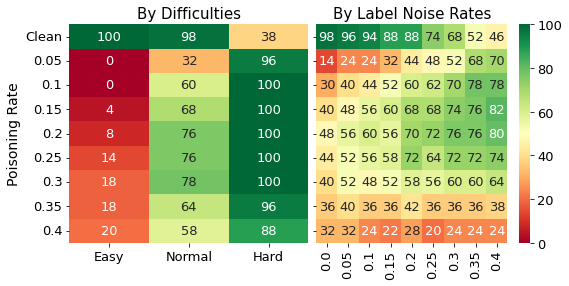

In [11]:
# Baseline subfigures at top row
# Keep subtitles, but remove X labels

FONTSIZE = 13
FIGSIZE = (8, 4)
# X_LABELS = ['Dataset Difficulty', 'Label Noise Rate']
TITLES = ['By Difficulties', 'By Label Noise Rates']
CMAP = 'RdYlGn'

plt.rcParams["font.size"] = FONTSIZE
fig, axes = plt.subplots(1, 2, sharey=True, figsize=FIGSIZE)

sns.heatmap(pivot_1, ax=axes[0], annot=True, fmt='.0f', cmap=CMAP, vmin=0, vmax=100, cbar=False)
axes[0].set_ylabel('Poisoning Rate', fontsize=FONTSIZE+1)

sns.heatmap(pivot_2, ax=axes[1], annot=True, fmt='.0f', cmap=CMAP, vmin=0, vmax=100)
axes[1].set_ylabel('')

for i, ax in enumerate(axes):
    # ax.set_xlabel(X_LABELS[i], fontsize=FONTSIZE+1)
    ax.set(xlabel=None)
    ax.set_title(TITLES[i], fontsize=FONTSIZE+2)

plt.tight_layout(pad=0.6)
plot_heatmap = os.path.join(path_output, 'synth_heatmap_baseline.svg')
plt.savefig(plot_heatmap, dpi=300)
print(f'Save to: {plot_heatmap}')